# Google Text Normalization Challenge: English Language

Text normalization is defined as the process of transforming text into a single canonical form. Normalizing text before storing or processing it, allows for separation of concerns, since input is then guaranteed to be consistent before operations are performed on it.

Text normalization has seen a huge advancement in technology with the implementation of deep neural networks. Advancements in AI and Processing power has enabled us to process enormous amounts of data rapidly learning from them and producing reliable outputs as required.

Google’ text normalization challenge follows the aftermath of a research paper produced by Google researchers Richard Sporat and Navdeep Jaitly. What they have been trying to do is to design a deep neural network to automate the process of text  normalization, given a corpus of labeled text data in the order of a few billion words along with their normalized function. 

The goal of this research is to produce DNN model which can efficiently translate written format input into readable output. Example: “15/1/1995” to “Fifteenth January Nineteen Ninety-Five.”

According to the research led by Sporat and Jaitly, they have tried training the model using two types of Neural Network.
1.	Text Normalization using LSTM
2.	Attention Based RNN Sequence to Sequence Model

Both of the above models produced a reasonable amount of accuracy but not to an industry ready standard. 
To further improve the model, google released a huge labeled dataset along with a cash prize on Kaggle with the hopes of the community at large coming up with a better solution. 

By doing this, some interesting results are obtained wherein people have used regular expressions to obtain near perfect results. But this is not ideal since there is no machine intelligence involved and the entirety of the code is hard-coded to find values which will most definitely fail when it comes to real world implementation.

Another method which can be used is the XGBoost or Extreme Gradient Boosting method which has quite often proved to be a winning method for many in Kaggle competitions. It operates as a boosted random forest method and has shown comparatively good results. 
But the real dilemma is to build a pure DNN which can solve this problem effectively and efficiently. 

It is for the same reason, I have opted to use a recurrent neural network using LSTM (Long short-term memory) to attempt this task. The implemented model along with their step by step details have been explained below in each stage of the model writtern as comments and Text.


# Importing all the important Libraries:

Since I will be using Keras to build our neural network, I will import Keras Library along with other libraries for data manipulation and visualization which we will be using.

I will be operating Keras on a TensorFlow Backend. 

Some of the other Useful Libraries we will be importing are "re" for Regular Expressions and "gc" for garbage collection.

In [1]:
import pandas as pd
import numpy as np
import gc
import re
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt

Using TensorFlow backend.


Defining Initial Parameters:

We set the maximum number of features to 10 and the letter space to 10.
We initialize an object called "space_padded_tokens" as an empty list.

In [2]:
max_num_features = 10
space_letter = 0
space_padded_tokens = []

Reading the input train and test dataset Files:

In [59]:
#In order to minimize run time of the code since i am using a slow processor, we only read the first  "100000" rows of the training data.
training_data = pd.read_csv("en_train.csv", nrows=100000)

#Max data size is set as the length of the read data.
max_data_size = len(training_data)

#We print out all the unique classes in the dataset.
training_data['class'].unique()

array(['PLAIN', 'PUNCT', 'DATE', 'LETTERS', 'CARDINAL', 'VERBATIM',
       'DECIMAL', 'MEASURE', 'MONEY', 'ORDINAL', 'TIME', 'ELECTRONIC',
       'DIGIT', 'FRACTION', 'TELEPHONE', 'ADDRESS'], dtype=object)

In [4]:
#Reading the test dataset as test_dataset
test_dataset = pd.read_csv("en_test.csv")

# Basic Dataset Analysis: (Reading Head, Info and Discription)

In [65]:
#Checking the head of the Training DAtaset:
training_data.head()

,sentence_id,token_id,class,before,after
0,0,0,PLAIN,Brillantaisia,Brillantaisia
1,0,1,PLAIN,is,is
2,0,2,PLAIN,a,a
3,0,3,PLAIN,genus,genus
4,0,4,PLAIN,of,of


In [6]:
#Checking the info of the Training dataset:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
sentence_id    100000 non-null int64
token_id       100000 non-null int64
class          100000 non-null object
before         100000 non-null object
after          100000 non-null object
dtypes: int64(2), object(3)
memory usage: 3.8+ MB


In [7]:
#Checking the head of the Test Dataset:
test_dataset.head()

,sentence_id,token_id,before
0,0,0,Another
1,0,1,religious
2,0,2,family
3,0,3,is
4,0,4,of


In [8]:
#Checking the info of the Test Dataset:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088564 entries, 0 to 1088563
Data columns (total 3 columns):
sentence_id    1088564 non-null int64
token_id       1088564 non-null int64
before         1088551 non-null object
dtypes: int64(2), object(1)
memory usage: 24.9+ MB


Using MatPlotLib and Seaborn to visualize the Data:

In [9]:
import seaborn as sns

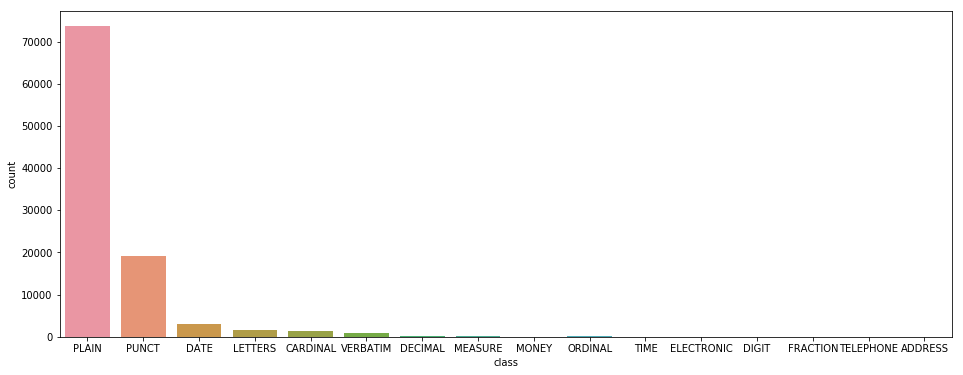

In [10]:
#Plotting a count graph for the "Class" column of the data:
fig = plt.figure(figsize=(16,6))
sns.countplot(x='class',data = training_data)

# Exploratory Data Analysis on the Dataset:

In [11]:
#Checking the number of datapoints in each class group:
training_data['class'].value_counts().sort_values(ascending = False)

PLAIN         73686
PUNCT         19166
DATE           2943
LETTERS        1545
CARDINAL       1266
VERBATIM        789
MEASURE         152
DECIMAL         135
ORDINAL         108
DIGIT            51
MONEY            48
ELECTRONIC       45
TELEPHONE        37
FRACTION         16
TIME             12
ADDRESS           1
Name: class, dtype: int64

In [12]:
#Checking for any null values in the dataset:
training_data.isnull().any()

sentence_id    False
token_id       False
class          False
before         False
after          False
dtype: bool

In [13]:
#Checking the head of the "PUNCT" class group:
training_data[training_data['class']=='PUNCT'].head()

,sentence_id,token_id,class,before,after
9,0,9,PUNCT,.,.
17,1,7,PUNCT,.,.
25,2,7,PUNCT,",",","
28,2,10,PUNCT,",",","
31,2,13,PUNCT,",",","


In [14]:
#Checking the head of the "DATE" class group:
training_data[training_data['class']=='DATE'].head()

,sentence_id,token_id,class,before,after
10,1,0,DATE,2006,two thousand six
51,3,7,DATE,2007,two thousand seven
80,5,0,DATE,2008,two thousand eight
111,8,1,DATE,4 March 2014,the fourth of march twenty fourteen
147,11,1,DATE,"April 10, 2013",april tenth twenty thirteen


In [15]:
#Cheking the head of the "Letters" class group:
training_data[training_data['class']=='LETTERS'].head()

,sentence_id,token_id,class,before,after
11,1,1,LETTERS,IUCN,i u c n
115,9,2,LETTERS,BC,b c
159,14,2,LETTERS,ALCS,a l c s
201,18,2,LETTERS,C.,c
205,18,6,LETTERS,J.,j


In [16]:
num_train_sent = len(training_data.sentence_id.unique())
num_train_sent

7999

In [17]:
train_sent = training_data.groupby("sentence_id")["sentence_id"].count()
train_sent.describe()

count    7999.000000
mean       12.501563
std         6.398277
min         2.000000
25%         7.000000
50%        12.000000
75%        18.000000
max        82.000000
Name: sentence_id, dtype: float64

# Data Visualization using Seaborn:

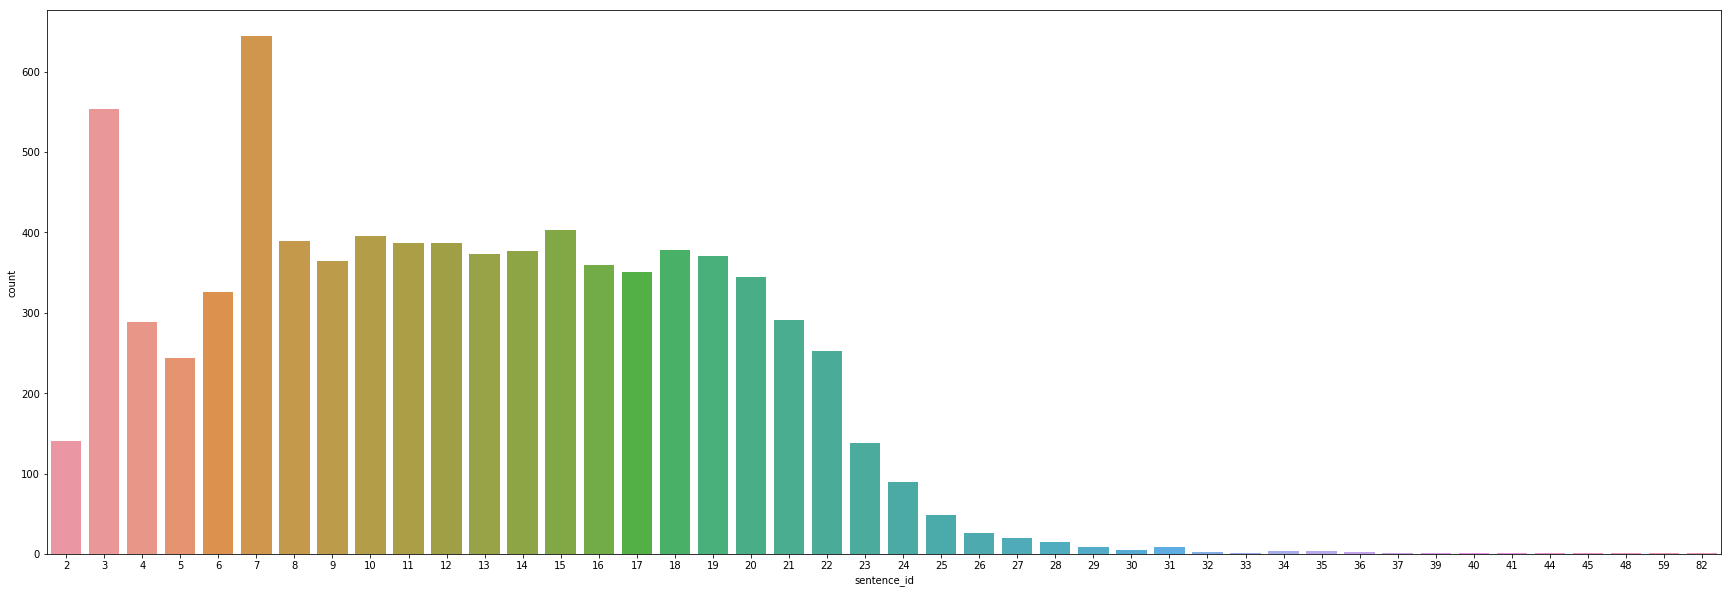

In [18]:
#Plotting a count plot for sentence id int he train data:
fig, ax = plt.subplots(1,1, figsize=(30,10))
figure_length = sns.countplot(train_sent, ax = ax)

In [19]:
test_sent = test_dataset.groupby("sentence_id")["sentence_id"].count()
test_sent.describe()

count    70000.000000
mean        15.550914
std          5.763962
min          2.000000
25%         11.000000
50%         16.000000
75%         20.000000
max        249.000000
Name: sentence_id, dtype: float64

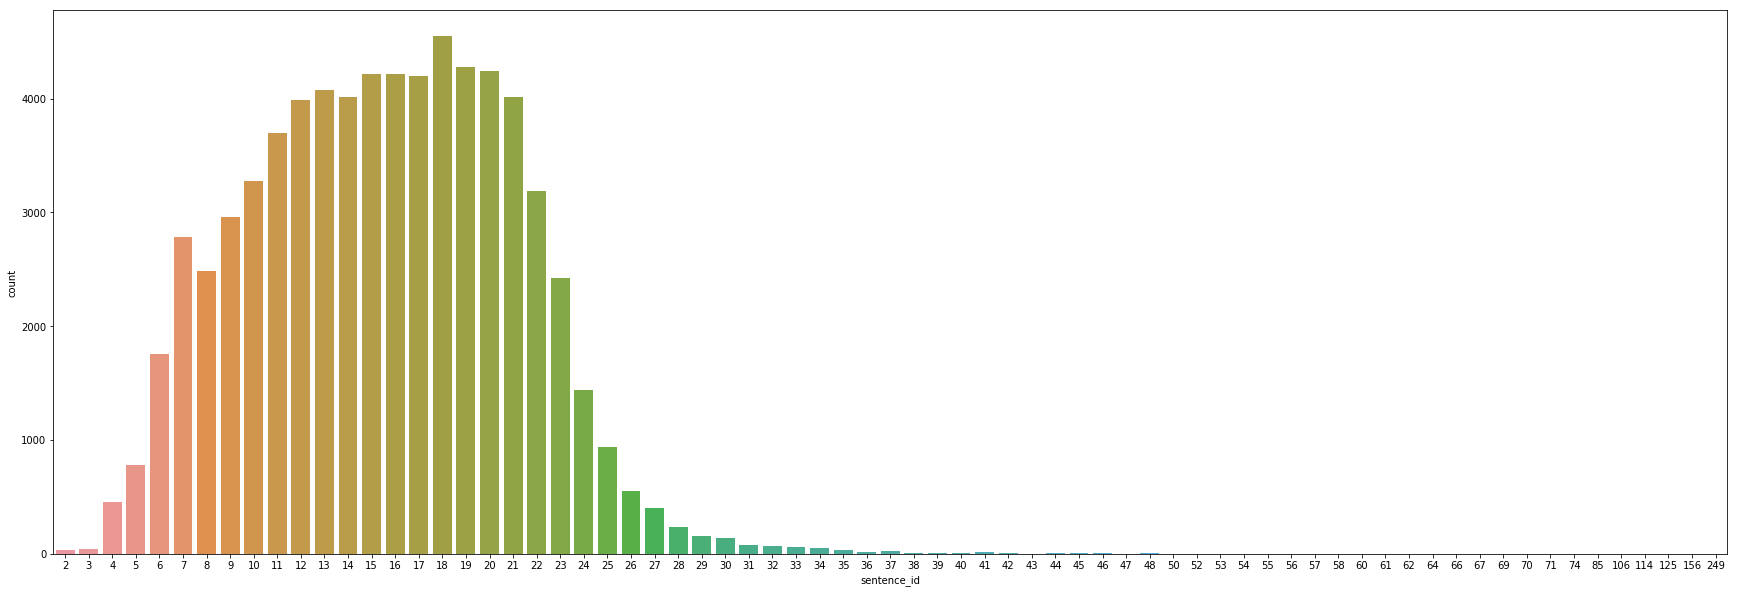

In [20]:
#Plotting a countplot of the sentence id in the test data:
fig, ax = plt.subplots(1,1, figsize=(30,10))
figure_length = sns.countplot(test_sent, ax = ax)

# Defining the Data and labels:

In [60]:
#Factorizing the "CLASS" column of the training data:
encoded_classes = pd.factorize(training_data['class'])

#Defining the Xdata, Ydata and Labels:
x_data = []
labels = encoded_classes[1]
y_data = encoded_classes[0]

#Garbage collect funtion and initializing an object "count" as zero:
gc.collect()
count = 0

In [22]:
#Checking the Labels:
labels

Index(['PLAIN', 'PUNCT', 'DATE', 'LETTERS', 'CARDINAL', 'VERBATIM', 'DECIMAL',
       'MEASURE', 'MONEY', 'ORDINAL', 'TIME', 'ELECTRONIC', 'DIGIT',
       'FRACTION', 'TELEPHONE', 'ADDRESS'],
      dtype='object')

In [63]:
#Checking the first 25 Y-Data points:
y_data[:25]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [62]:
#Checking the shape of Y Data:
y_data.shape

(100000,)

In [30]:
encoded_classes[1]

Index(['PLAIN', 'PUNCT', 'DATE', 'LETTERS', 'CARDINAL', 'VERBATIM', 'DECIMAL',
       'MEASURE', 'MONEY', 'ORDINAL', 'TIME', 'ELECTRONIC', 'DIGIT',
       'FRACTION', 'TELEPHONE', 'ADDRESS'],
      dtype='object')

# Pre-Processing the Data:

In [68]:
'''
In order to make the data suitable for feeding into the neural network, we have to conver the text data into neumaric data.
Hence for each word in the "Before" column, we split each character, conert it into its suitable unicode format and store each
word as an individual row in X_Data
'''
for before_value in training_data['before'].values:
    row = np.ones(max_num_features, dtype=int) * space_letter
    for before_value_char, i in zip(list(str(before_value)), np.arange(max_num_features)):
        row[i] = ord(before_value_char)
    count+=1
    x_data.append(row)

In [69]:
'''
We define a funtion to calculate the "Flat context windows":
As described in the paper published by Sporat and Jaitley, In order for the prediction to be more accurate, we can include 
the context of the texts which appears before and after the word we are taking into consideration. Therefore, in this funtion,
we make a context windows which passes over the entire list of X-Data rows and return a new list of rows where the word we are
taking into consideration in each row is enclosed on either side by words whihc come before and after it in the original dataset.
'''
def make_flat_context_windows(data, pad_size, max_num_features, boundary_letter):
    #Initializing an object pad as an array of zeros with length eual to Max number of features = 10
    pad = np.zeros(shape=max_num_features)
    
    #adding number of pads depending on the padsize
    pads = [pad for _ in  np.arange(pad_size)]
    
    #Adding the pads to either sides of the data
    data = pads + data + pads
    
    #Initializing an empty list for returning the final list
    flattened_context_windows = []
    
    #Defining the context windows whihc will pass over the dataset.
    for lower_bound in np.arange(len(data) - pad_size * 2):
        #initializing another empty list to make the new flattened context list
        flattened_context_window = []
        context_window_size = pad_size * 2 + 1
        upper_bound = lower_bound + context_window_size
        context_window = data[lower_bound:upper_bound]
        
        #for each word in the context window, we append it to the "flattened_context_window" list along with the boundry letters
        for word in context_window:
            flattened_context_window.append([boundary_letter])
            flattened_context_window.append(word)
        flattened_context_window.append([boundary_letter])
        
        #adding all the modified rows into the "flattened_context_windows" list and returning it.
        flattened_context_windows.append([int(word) for row in flattened_context_window for word in row])
    return flattened_context_windows

# Defining x_train and y_train:

In [70]:
#Setting the max number of X data and Y data data to a 100000 data points:
x_data = x_data[:max_data_size]
y_data = y_data[:max_data_size]

#Calling the "Context windows funtion on the X_Data:
x_data = np.array(make_flat_context_windows(x_data, pad_size = 1, max_num_features= max_num_features, boundary_letter=-1))

#Garbage collection
gc.collect()

0

In [71]:
#Converting all the lists and arrays into a numpy array so it can be fed into the DNN
x_train = np.array(x_data)
y_train = np.array(y_data)

#Garbage Collection
gc.collect()

0

In [72]:
#Checking the shape of the X_train data
x_train.shape

(100000, 34)

In [73]:
#Checking the shape of the Y_train data
y_train.shape

(100000,)

# Splitting the Data set to train and validation data:

In [74]:
#Using the train_test_split function to split the training data into the training and validation dataset 
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1)

In [75]:
#Checking the total number of classes
num_classes = len(labels)
num_classes

16

Reshaping the dataset to input into the training model:

In [76]:
#Since the class column has 16 diffent classes, we are reshaping the y_data from a one column dataset into a 16 column dataset,
#where each column represents a diffent class:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

#Checking the shape of the x_train data
print(x_train.shape)

(90000, 34)


In [77]:
#Reshaping the X_data from (90000,34) to (90000,34,1) to feed into the DNN
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))

In [78]:
#Checking the x_train shape
x_train.shape

(90000, 34, 1)

In [79]:
#Checking the y_train shape
y_train.shape

(90000, 16)

# Building the layers of the LSTM neural network:

In [80]:
#Initializing the Keras LSTM model:
model = Sequential()

#Adding an LSTM Layer with output shape set to 128 and dropout rate set to 20%
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=((max_num_features * 3) + 4, 1)))

#Adding a dense layer with an output shape of 32 and a relu activation funtion:
model.add(Dense(32, activation='relu'))

#Adding a dropout layer with a rate of 20% again:
model.add(Dropout(0.2))

#Adding a dense later with a softmax activation with the output size equal to the length of the labels = 16
model.add(Dense(len(labels), activation='softmax'))

Summary of the model:

In [81]:
#Checking the model summary:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
Total params: 71,216
Trainable params: 71,216
Non-trainable params: 0
_________________________________________________________________


# Compiling, Fitting, and Evaluating the model:

In [82]:
#Compiling the model with the rmsprop optimizer and "categoriacal crossentropy" as the loss metric and also checking accuracy:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
#Fitting the model on the validation data with batch size set to 128 for a total of 10 epochs:
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_valid, y_valid))

Train on 90000 samples, validate on 10000 samples
Epoch 1/10
90000/90000 [==============================] - 52s 583us/step - loss: 0.4440 - acc: 0.8867 - val_loss: 0.2881 - val_acc: 0.9247
Epoch 2/10
90000/90000 [==============================] - 51s 563us/step - loss: 0.2304 - acc: 0.9438 - val_loss: 1.1888 - val_acc: 0.5877
Epoch 3/10
90000/90000 [==============================] - 50s 558us/step - loss: 0.1938 - acc: 0.9523 - val_loss: 0.1424 - val_acc: 0.9689
Epoch 4/10
90000/90000 [==============================] - 50s 561us/step - loss: 0.1748 - acc: 0.9566 - val_loss: 0.2981 - val_acc: 0.9176
Epoch 5/10
90000/90000 [==============================] - 50s 552us/step - loss: 0.1640 - acc: 0.9603 - val_loss: 0.2599 - val_acc: 0.9353
Epoch 6/10
90000/90000 [==============================] - 50s 559us/step - loss: 0.1556 - acc: 0.9621 - val_loss: 0.1644 - val_acc: 0.9585
Epoch 7/10
90000/90000 [==============================] - 49s 548us/step - loss: 0.1488 - acc: 0.9637 - val_loss: 0.

In [84]:
#collecting any garbage
gc.collect()

3780

Evaluating the model:

In [85]:
#Evaluating the model and assigning it to score:
score = model.evaluate(x_valid, y_valid, verbose=0)

In [86]:
#Desplaying score:
score

[0.16165324929729105, 0.95089999999999997]

Checking thr accuracy on the validation dataset:

In [87]:
#Printing the accuracy on the validation set:
print("Accuracy on validaton dataset")
print(score[1])

Accuracy on validaton dataset
0.9509


# Plotting the Accuracy and Lose Graphs

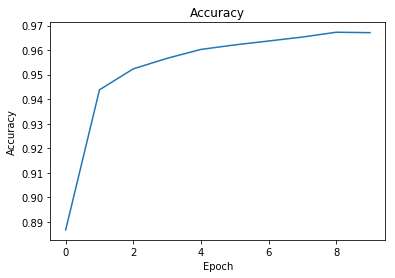

In [88]:
#Ploting the accuracy vs epoch graph using matplotlib:
plt.plot(history.history['acc'])
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

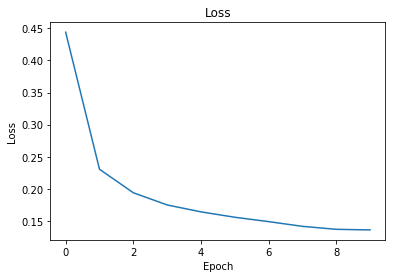

In [89]:
#Plotting the loss vs Epoch graph using matplotlib:
plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

# Predicting values for the test split data and transffering to file:

In [90]:
#Using the trained model to predict on the validation dataset
predicted_valid = model.predict(x_valid)

In [91]:
#Obtaining the predicted value of the Labels
predicted_valid = [labels[np.argmax(x)] for x in predicted_valid]

#Generating characters of the Data
x_valid = [[chr(x) for x in y[2 + max_num_features: 2 + max_num_features * 2]] for y in x_valid]
#Joining all the characters in the x_valid data
x_valid = [''.join(x) for x in x_valid]
#Replacing the patterns for the input x in x_valid
x_valid = [re.sub('a+$', '', x) for x in x_valid]

In [92]:
#Collecting garbage values
gc.collect()

4825

In [93]:
#Creating a new dataframe with "Data and "Predict" Columns:
df_predicted_valid = pd.DataFrame(columns=['data', 'predict'])

#Filling the 'data' column with x_valid values:
df_predicted_valid['data'] = x_valid

#Filling the 'predict' column with predicted_valid values
df_predicted_valid['predict'] = predicted_valid

#Storing the dataframe in a csv file:
df_predicted_valid.to_csv('validation_pred_lstm.csv')

# Preprocessing and predicting seperate test dataset:

In [94]:
#Test data Values
test_data = test_dataset['before'].values

In [95]:
#Converting the test data into unicode format and stored as rows of unicode values in a similar way in which we 
#Preprocessed the training data
def make_encoded_space_padded_tokens(data, max_num_features, space_char):
    #creating an empty list for space padded tokens
    space_padded_tokens = list()
    for before_value in data:
        #Initializing the space padded token with a numpy array of length ezual to max_num_features = 10
        space_padded_token = np.ones(max_num_features, dtype=int) * space_char
        before_value_c_str = list(str(before_value))
        for before_value_char, i in zip(before_value_c_str, range(max_num_features)):
            #Replacing the char values with unicode of their corrosponding values
            space_padded_token[i] = ord(before_value_char)
        #Appenidng to space padded tokens and returning it    
        space_padded_tokens.append(space_padded_token)
    return space_padded_tokens

In [96]:
#Calling the padded tokens function on the test data
test_data = make_encoded_space_padded_tokens(data=test_data, max_num_features=max_num_features, space_char=0)

In [97]:
#Calling the flat context windows functioin on the test data to make it suitable to test in our model:
test_data = np.array(make_flat_context_windows(data=test_data, pad_size=1, max_num_features=max_num_features, boundary_letter=-1))

In [98]:
#Reshaping the test data to input into the Deep neural network:
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))

In [99]:
#Predicting the values on the test data using our model
predicted_data = model.predict(test_data)

In [100]:
#Obtaining the predicted value of the Labels
predicted_data = [labels[np.argmax(char)] for char in predicted_data]

#Generating characters of the Data
test_data = [[chr(wrd) for wrd in char[2 + max_num_features: 2 + max_num_features * 2]] for char in test_data]
#Joining all the characters in the x_valid data
test_data = [''.join(wrd) for wrd in test_data]
#Replacing the patterns for the input x in x_valid
test_data = [re.sub('a+$', '', wrd) for wrd in test_data]

In [101]:
#Collecting garbage values
gc.collect()

0

# Transferring output to file:

In [102]:
#Creating a new dataframe with "ID", "Data and "Predict" Columns:
df_predicted = pd.DataFrame(columns=['id','data', 'predict'])

#Filling the "ID" column with numbering of the data
df_predicted['id'] = test_dataset.sentence_id.astype(str) + '_' + test_dataset.token_id.astype(str)

#Filling the 'data' column with test_data values:
df_predicted['data'] = test_data

#Filling the 'predict' column with predicted_data values
df_predicted['predict'] = predicted_data

#Storing the dataframe in a csv file:
df_predicted.to_csv('pred_lstm.csv')

In [105]:
#Showing a sample of the predicted outputs:
df_predicted.sample(50)

,id,data,predict
653024,42058_2,(         ,PUNCT
971849,62507_13,"""         ",PUNCT
240940,15502_15,Norfolk   ,PLAIN
717992,46198_1,All       ,LETTERS
654283,42139_1,is        ,PLAIN
1015425,65318_10,(         ,PUNCT
999140,64269_4,is        ,PLAIN
548541,35300_0,GS        ,LETTERS
38601,2488_15,Branch    ,PLAIN
985892,63410_7,Jewish    ,PLAIN


From the above prediction model, The classification performed with an accuracy of 95% after running for 10 Epochs. But we used only the first 100000 data points to achieve this result. This is owed to the fact that I am running this on an old computer with a Nvidia GTX560 graphics card and couldnt afford to process large amounts of data. 

Some of the methods I have tried to improve the accuracy are as follows:
1. Adding more hidden layers to the neural network.
2. Playing around with the optimizers used.
3. Trying different batch sizes and epochs.
4. Altering the dense and the dropout layers.
5. Altering the dataset to be more balanced.

What I plan to do with access to the DGX1:

While the implementation of this algorithm has not given ideal results, With the help of better, more powerful processing power in the likes of DGX1, I will be able to work on the entire set of data and can optimize the hyper parameters for achieving the desired results without the constraint of large processing time.

1. Firstly, i would use all the data from the given dataset to train my model instead of using just the first 100,000 datapoints.
2. I would increse the number of Epochs and test the performance of the model.
3. I would experiment with adding more number of hidden layers to see if there is any increse in performance.
4. I would experiment with decresing the batch size number and validating the performance.
5. I would ofcourse tweak the hyper-parameters and check to see if there is any changes to the result after incresing the size of the dataset using different optimizers and types of hidden layers.

The most significant advantage of using a super computer like the DGX1 is the amount of time we can save in ruuning the time consuming models. With access to it and a time period of 30 days, I am confident, I can increse the prediction accuracy by a good margin.

Text normalization is a very exciting area of Deep Learing and still has a long way to go but is quickly catching up. With the rapid increse in technology, The field of Natural Language Processing will unlock unlimited potential in the artificial intelligence sector. This is a a small part of my contribution towards that goal. 

Thank you.

